# Download a wind timeseries from CMEMS and deal with 'expver' issue

1) Access the Copernicus

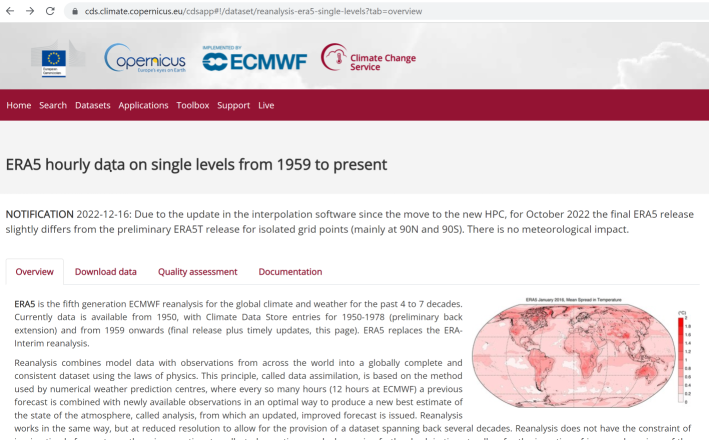

2) In 'Download Data', select the options... in this case, only the wind components u e v at 10 m

3) Select the sub-region of the interest and the format  

4) Click at 'Show API request', and the it will deliver the Python code for the query... copy & paste in the notebook!.  

It is necessary to install the package 'cdsapi', and to have an account e be logged. The code is straghtforward, and can be changed accordingly. The example below I selecting data for a single point (0.5 degree resolution), so it is quite easy to find the nearesta point someone needs.


In [1]:
import cdsapi

c = cdsapi.Client()

c.retrieve(
    'reanalysis-era5-single-levels',
    {
        'product_type': 'reanalysis',
        'format': 'netcdf',
        'variable': [
            '10m_u_component_of_wind', '10m_v_component_of_wind',
        ],
        'year': [
            '2022', '2023',
        ],
        'month': [
            '01', '02', '03',
            '04', '05', '06',
            '07', '08', '09',
            '10', '11', '12',
        ],
        'day': [
            '01', '02', '03',
            '04', '05', '06',
            '07', '08', '09',
            '10', '11', '12',
            '13', '14', '15',
            '16', '17', '18',
            '19', '20', '21',
            '22', '23', '24',
            '25', '26', '27',
            '28', '29', '30',
            '31',
        ],
        'time': [
            '00:00', '01:00', '02:00',
            '03:00', '04:00', '05:00',
            '06:00', '07:00', '08:00',
            '09:00', '10:00', '11:00',
            '12:00', '13:00', '14:00',
            '15:00', '16:00', '17:00',
            '18:00', '19:00', '20:00',
            '21:00', '22:00', '23:00',
        ],
        'area': [
            -21, -40.5, -21,
            -40.5,
        ],
    },
    'vento_ERA5.nc')   # eu mudei o nome para minha conveniênica... e outros parâmetros também podem ser alterados!

2023-01-21 16:27:01,226 INFO Welcome to the CDS
2023-01-21 16:27:01,229 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels
2023-01-21 16:27:01,565 INFO Request is queued
2023-01-21 16:27:02,825 INFO Request is running
2023-01-21 16:37:25,933 INFO Request is completed
2023-01-21 16:37:25,938 INFO Downloading https://download-0005-clone.copernicus-climate.eu/cache-compute-0005/cache/data6/adaptor.mars.internal-1674329769.4357646-1514-9-21723732-0526-44b6-b5fd-64b956dbd1fb.nc to vento_ERA5.nc (108.5K)
2023-01-21 16:37:28,252 INFO Download rate 47K/s                                                                       


Result(content_length=111132,content_type=application/x-netcdf,location=https://download-0005-clone.copernicus-climate.eu/cache-compute-0005/cache/data6/adaptor.mars.internal-1674329769.4357646-1514-9-21723732-0526-44b6-b5fd-64b956dbd1fb.nc)

# Exploring the content of the downloaded file!  

This is better done in a second notebook. But let's do here for convenience. In the case of need to re-start the kernel, best to commnet the download part.


In [60]:
import netCDF4
import matplotlib.pyplot as plt
import numpy as np

#### Load and show the fields

In [67]:
nc = netCDF4.Dataset('Vento_ERA5.nc')

# imprime o nome das variáveis
for i in nc.variables:
    print(i)
    
print()
print()

#imprime metadata
for i in nc.variables:
    print(nc.variables[i])
    print()
    print()

longitude
latitude
expver
time
u10
v10


<class 'netCDF4._netCDF4.Variable'>
float32 longitude(longitude)
    units: degrees_east
    long_name: longitude
unlimited dimensions: 
current shape = (1,)
filling on, default _FillValue of 9.969209968386869e+36 used


<class 'netCDF4._netCDF4.Variable'>
float32 latitude(latitude)
    units: degrees_north
    long_name: latitude
unlimited dimensions: 
current shape = (1,)
filling on, default _FillValue of 9.969209968386869e+36 used


<class 'netCDF4._netCDF4.Variable'>
int32 expver(expver)
    long_name: expver
unlimited dimensions: 
current shape = (2,)
filling on, default _FillValue of -2147483647 used


<class 'netCDF4._netCDF4.Variable'>
int32 time(time)
    units: hours since 1900-01-01 00:00:00.0
    long_name: time
    calendar: gregorian
unlimited dimensions: 
current shape = (9140,)
filling on, default _FillValue of -2147483647 used


<class 'netCDF4._netCDF4.Variable'>
int16 u10(time, expver, latitude, longitude)
    scale_factor: 0.

#### Checking the coordinates, and in fact, we have just one point!

In [9]:
lon = nc.variables['longitude'][:]
lat = nc.variables['latitude'][:]

print(lon, lat)

[-40.5] [-21.]


#### Converting the model time to 'datetime'

In [26]:
tempo = netCDF4.num2date(nc.variables['time'], nc.variables['time'].units, only_use_cftime_datetimes=False)

print(tempo[0:5])

[real_datetime(2023, 1, 16, 0, 0) real_datetime(2023, 1, 16, 1, 0)
 real_datetime(2023, 1, 16, 2, 0) real_datetime(2023, 1, 16, 3, 0)
 real_datetime(2023, 1, 16, 4, 0)]


#### It should start at 2022, 1, 1, 0, 0, 0 as requested in the API - Weird... 

In [45]:
print(tempo[0])
print(tempo[-1])

2023-01-16 00:00:00
2023-01-15 23:00:00


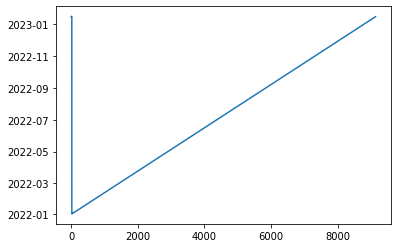

In [27]:
plt.plot(tempo)

#### In fact, quite weird... and also considering that V10 and U10 have the dimensions "int16 v10(time, expver, latitude, longitude)"

#### What the fuck is 'expver'?
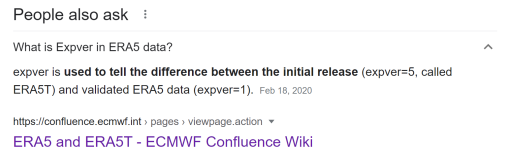



In [68]:
u = nc.variables['u10'][:]

u.shape

(9140, 2, 1, 1)

#### The last two dimensions are the coordinates, but what could be the 2.nd?
#### Exploring further...

<class 'numpy.ma.core.MaskedArray'>


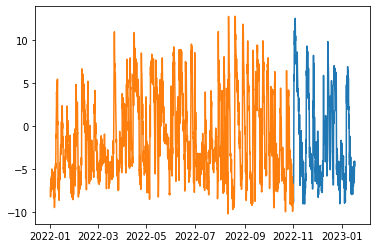

In [70]:
u = nc.variables['u10'][:].squeeze()
v = nc.variables['v10'][:].squeeze()

print(type(u))

plt.plot(tempo,v[:,0])
plt.plot(tempo,v[:,1])

In [69]:
junta = []
for i in range(len(v[:,0])):
    print(i, tempo[i],v[i,0], v[i,1])
    
    if i == 30:
        break

0 2023-01-16 00:00:00 -6.452780028846094 --
1 2023-01-16 01:00:00 -6.576197144102331 --
2 2023-01-16 02:00:00 -6.335306514041292 --
3 2023-01-16 03:00:00 -6.106652708439087 --
4 2023-01-16 04:00:00 -5.888137985959915 --
5 2023-01-16 05:00:00 -5.79408924940488 --
6 2023-01-16 06:00:00 -5.729758515107012 --
7 2023-01-16 07:00:00 -5.33783050886837 --
8 2023-01-16 08:00:00 -5.03820312140493 --
9 2023-01-16 09:00:00 -4.608515771121889 --
10 2023-01-16 10:00:00 -4.291057582304148 --
11 2023-01-16 11:00:00 -4.165892349268079 --
12 2023-01-16 12:00:00 -4.08058420161221 --
13 2023-01-16 13:00:00 -4.223929859558547 --
14 2023-01-16 14:00:00 -4.186520139070112 --
15 2023-01-16 15:00:00 -4.088625543399443 --
16 2023-01-16 16:00:00 -4.08373081361591 --
17 2023-01-16 17:00:00 -4.138621711902678 --
18 2023-01-16 18:00:00 -4.359583799273617 --
19 2023-01-16 19:00:00 -4.593481958215321 --
20 2022-01-01 00:00:00 -- -7.114267796735042
21 2022-01-01 01:00:00 -- -7.650939955143887
22 2022-01-01 02:00:00 --

#### I think that this (the truncated time and 2 columns for the same variable, changing) is because I asked the data up to the date of the request. The link below explain what is the 'expver' and why this is done...

https://confluence.ecmwf.int/pages/viewpage.action?pageId=173385064

#### So, it is the case to merge the data in a single column and sort it cronologically

#### Transforming in 'np.array', the symbol '--' changes to a numeric flag of missing data, and can be used to joint the data

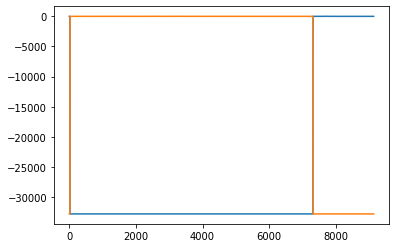

In [72]:
u = np.array(u)
v = np.array(v)

plt.plot(u)

-32767.0


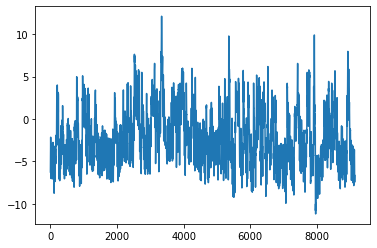

In [76]:
flag = np.min(u)
print(flag)

u2 = []
v2 = []
for i in range(len(tempo)):
    if u[i,0] != flag:
        u2.append(u[i,0])
        v2.append(v[i,0])
    else:
        u2.append(u[i,1])
        v2.append(v[i,1])
        
plt.plot(u2)

#### Sorting cronologically...

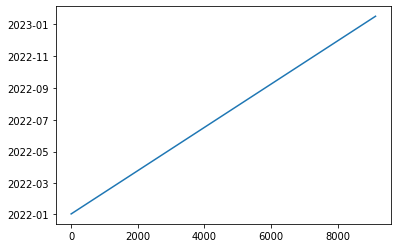

In [81]:
# monta a matriz
junta = np.hstack((
                 np.atleast_2d(np.array(tempo)).T,
                 np.atleast_2d(np.array(u2)).T,
                 np.atleast_2d(np.array(v2)).T
                 ))

# ordena usando o tmepo
junta = junta[junta[:,0].argsort()]

plt.plot(junta[:,0])

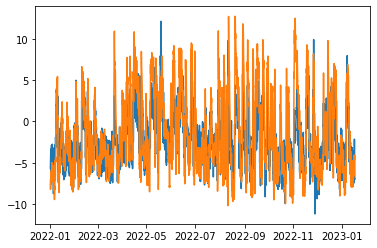

In [82]:
plt.plot(junta[:,0], junta[:,1])
plt.plot(junta[:,0], junta[:,2])

In [86]:
# saving
import pickle

# [tempo, u, v]
with open('Vento_ERA5_2022_2023.pkl', 'wb') as io:
    pickle.dump(junta, io)